In [35]:
import os
import itertools

import python_speech_features as psf
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import soundfile as sf
import librosa
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.io import wavfile

In [ ]:
sampling_freq, audio = wavfile.read("Data/genres_original/pop/pop.00000.wav")
mfcc_features = psf.mfcc(audio, sampling_freq, nfft=551)
filterbank_features = psf.logfbank(audio, sampling_freq, nfft=551)

In [37]:
print ('\nMFCC:\nNumber of windows =', mfcc_features.shape[0])
print ('Length of each feature =', mfcc_features.shape[1])


MFCC:
Number of windows = 2992
Length of each feature = 13


In [38]:
input_dir = 'Data/genres_original/'
sampled_dir = 'Data/genres_sampled/'

In [39]:
duration = 29  # seconds

for genre in os.listdir(input_dir):
    os.makedirs(os.path.join(sampled_dir, genre), exist_ok=True)

    for filename in os.listdir(os.path.join(input_dir, genre)):
        filepath = os.path.join(input_dir, genre, filename)
        audio, sr = librosa.load(filepath, sr=None)

        sample = librosa.resample(audio[:sr*duration], orig_sr=sr, target_sr=sr)

        output_filepath = os.path.join(sampled_dir, genre, filename)
        sf.write(output_filepath, sample, sr)

In [40]:
genres = []
for folder in os.listdir(sampled_dir):
    genres.append(folder)
print(genres)

['blues', 'hiphop', 'metal', 'pop']


In [41]:
df = pd.DataFrame()

i = 0
for path, subdirs, files in os.walk(sampled_dir):
    for subdir in subdirs:
        for filename in os.listdir(os.path.join(path, subdir)):
            filepath = os.path.join(path, subdir, filename)
            df.loc[i, 'path'] = filepath
            df.loc[i, 'genre'] = subdir
            i += 1

<Figure size 2000x1500 with 0 Axes>

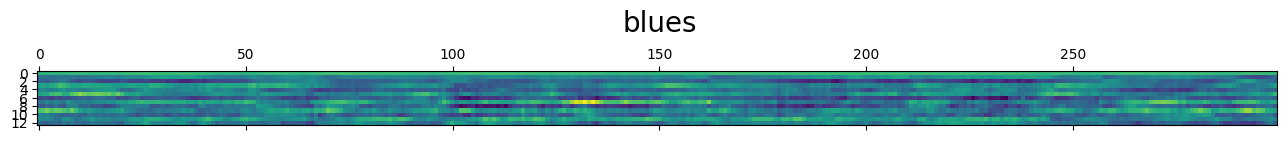

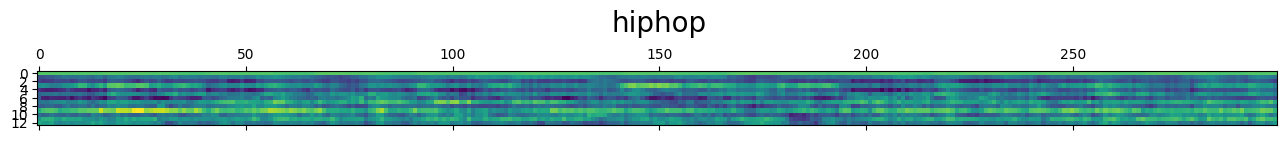

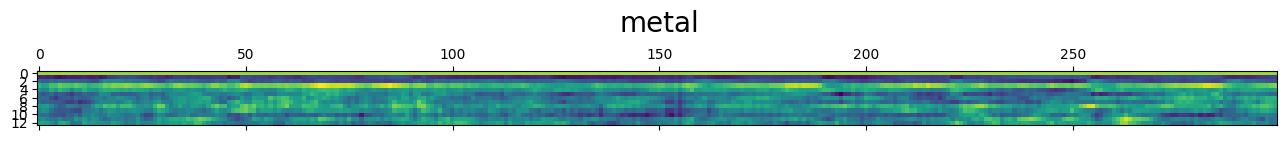

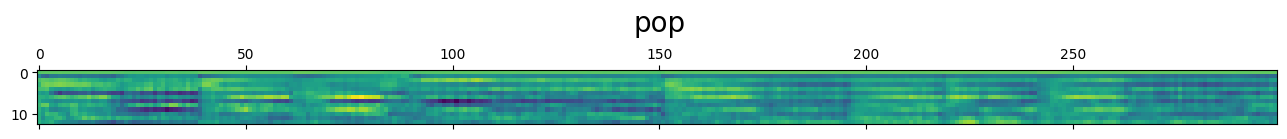

In [42]:
figure = plt.figure(figsize=(20,15))

for i, genre in enumerate(genres):
    file = df[df.genre == genre].iloc[0, 0]
    sampling_freq, audio = wavfile.read(file)
    mfcc_features = psf.mfcc(audio, sampling_freq, nfft=551)
    plt.matshow((mfcc_features.T)[:,:300])
    plt.text(150, -10, genre, horizontalalignment='center', fontsize=20)
plt.yscale('linear')
plt.show()

In [43]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['genre'])

In [65]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, t] = observation_matrix[:, t] * self.initial_prob.ravel()
            else:
                alpha[:, t] = observation_matrix[:, t] * np.dot(self.transition_matrix.T, alpha[:, t - 1])

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.transition_matrix, (observation_matrix[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mean[:, s].T, cov=self.covariances[:, :, s].T)

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = self.transition_matrix * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0]
        expected_transition = self._stochasticize(xi_sum)

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [66]:
hmm_models = []

for genre in train_df['genre'].unique():
    print(f'Training {genre}')
    genre_df = train_df[train_df['genre'] == genre]
    hmm = HMM(num_hidden_states=4)
    for path in genre_df['path']:
        sampling_freq, audio = wavfile.read(path)
        mfcc_features = psf.mfcc(audio, sampling_freq, nfft=551)
        mfcc_features = mfcc_features / np.amax(mfcc_features)
        mfcc_features = mfcc_features.T
        log_liklihood = hmm.train(mfcc_features, num_iterations=3)

    hmm_models.append((genre, hmm))
    hmm = None


Training hiphop
Training pop
Training metal
Training blues


In [67]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
y_true = []
y_pred = []

for path, genre in zip(test_df['path'], test_df['genre']):
    y_true.append(genre)
    sampling_freq, audio = wavfile.read(path)
    mfcc_features = psf.mfcc(audio, sampling_freq, nfft=551)
    mfcc_features = mfcc_features / np.amax(mfcc_features)
    mfcc_features = mfcc_features.T
    genre_scores = []
    max_score = -np.inf
    output_label = None
    for model_genre, model in hmm_models:
        score = model.score(mfcc_features)
        if score > max_score:
            max_score = score
            output_label = model_genre
        
    y_pred.append(output_label)


False
True
True
False
True
True
True
True
True
True
True
True
False
True
False
True
False
True
False
True
True
True
True
True
False
True
True
False
False
True
True
True
False
False
False
False
False
True
False
True
True
False
True
False
False
True
False
True
False
True
True
True
True
False
True
True
False
False
True
True
True
True
False
True
False
False
False
True
True
True
True
True
False
False
True
False
False
True
True
True


Normalized confusion matrix
[[0.8  0.   0.2  0.  ]
 [0.3  0.2  0.   0.5 ]
 [0.55 0.   0.45 0.  ]
 [0.   0.   0.   1.  ]]


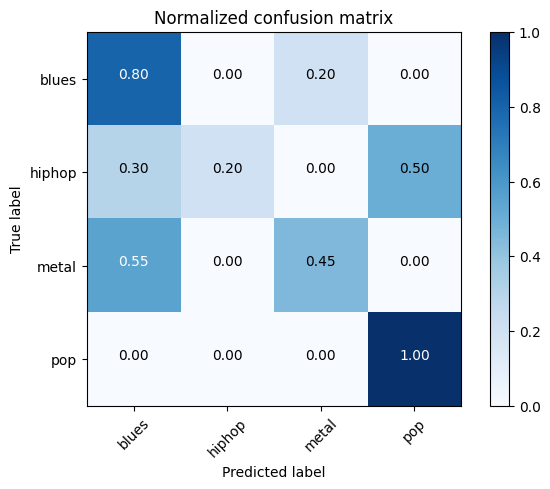

In [69]:
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=genres, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)

Accuracy: 0.6125
Precision: 0.7109557109557109
Recall: 0.6125
F1: 0.5706403659233847
